## Classificação de espécies de Pinguins

##### O time de biologistas da Antártica deseja classificar os pinguins catalogados dentro de cada espécie correta.

*   **User Story:** "Como diretor da base de observação do Arquipélago Palmer, quero realizar a classificação correta dos pinguins catalogados para que possamos monitorar o crescimento ou diminuição dos representantes de cada espécie"

###### O PenguinClassifier é um software desenvolvido para fornecer estes resultados para o time, a partir de um modelo de Machine Learning de Classificação.

**Data source**: Gorman KB, Williams TD, Fraser WR (2014) Ecological Sexual Dimorphism and Environmental Variability within a Community of Antarctic Penguins (Genus Pygoscelis). PLoS ONE 9(3): e90081. doi:10.1371/journal.pone.0090081

In [41]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

### Carga do dataset

In [42]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/gerolaleticia/mvp_sprint_4/main/data/penguins_size.csv"

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=',')

# Mostra as primeiras linhas do dataset
dataset.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


### Análise exploratória e limpeza dos dados

In [43]:
# checa valores nulos
dataset.isnull().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

O total de nulos não é significativo e não deve impactar no resultado final, aqui é opta-se pela exclusão de tais registros para sanitização da base.

In [44]:
# dropa nulos
dataset = dataset.dropna()

In [45]:
# checa valores duplicados
dataset.duplicated().sum()

0

In [46]:
# dropa features extras
dataset = dataset.drop(['island', 'sex'], axis=1)

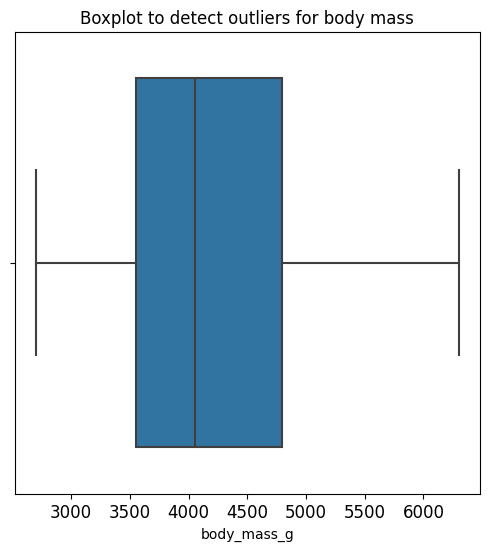

In [47]:
# checa outliers de massa corporal
plt.figure(figsize=(6,6))
plt.title('Boxplot to detect outliers for body mass', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=dataset['body_mass_g'])
plt.show()

Não foram detectados outliers significativos para tratamento.

In [48]:
# Checagem do percentual de registros de cada espécie
# Esta etapa é importante para verificar se temos registros suficientes para a classificação multi-label
print(dataset['species'].value_counts())
print()

# Get percentages of each species
print(dataset['species'].value_counts(normalize=True))

Adelie       146
Gentoo       120
Chinstrap     68
Name: species, dtype: int64

Adelie       0.437126
Gentoo       0.359281
Chinstrap    0.203593
Name: species, dtype: float64


**Ponto de atenção:** há mais espécies Adelie e Gentoo do que Chinstrap, porém possuímos registros suficientes de cada espécie para prosseguir com a modelagem.

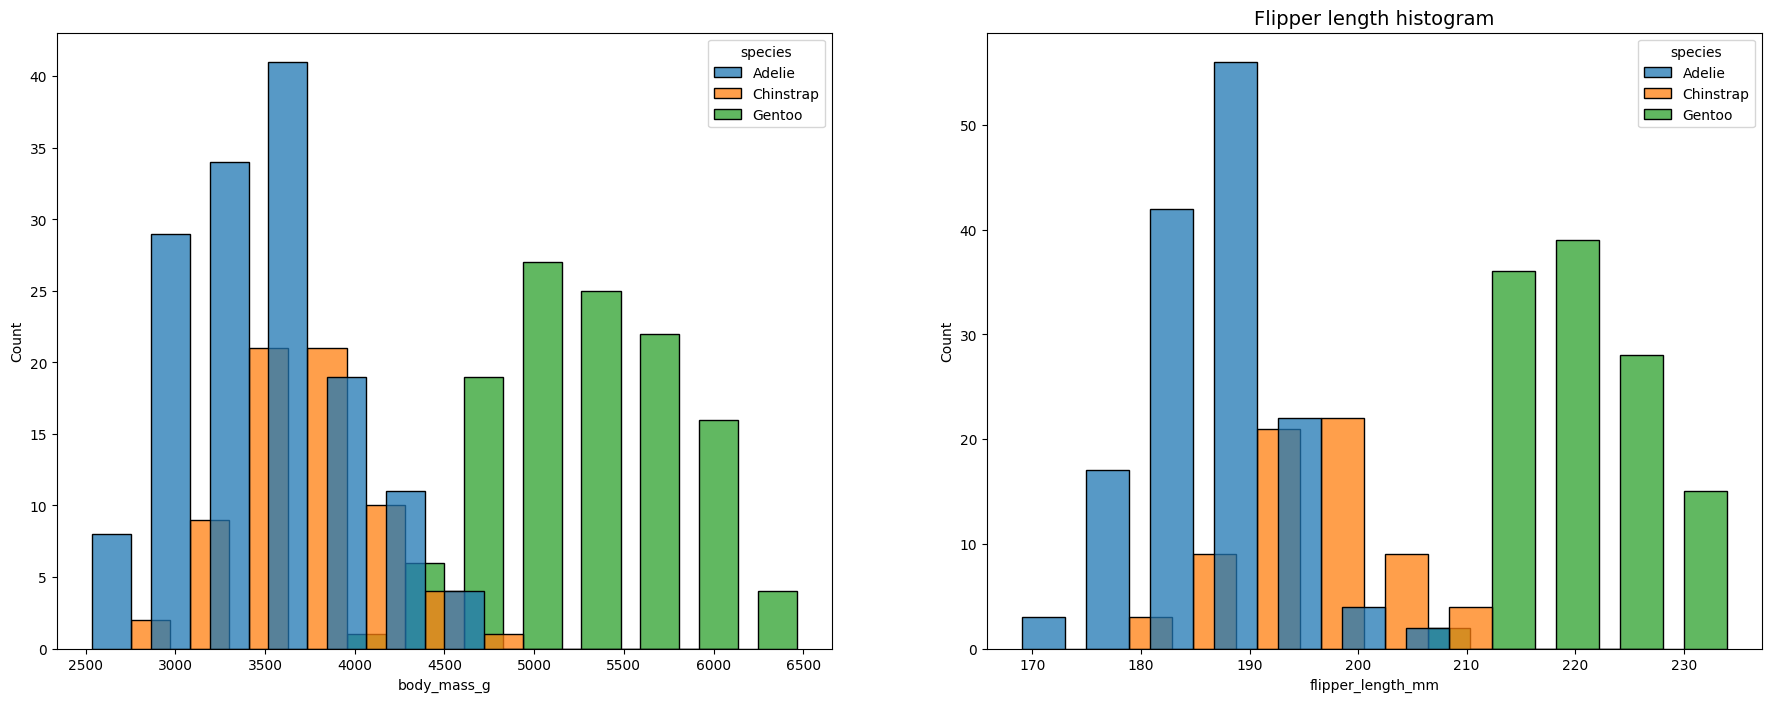

In [49]:
# Configura os plots para checagem de distribuição de massa corporal de cada espécie
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Cria histograma da distribuição de 'body_mass_g' para cada espécie
adelie = dataset[dataset['species']=='Adelie']['body_mass_g']
gentoo = dataset[dataset['species']=='Gentoo']['body_mass_g']
chinstrap = dataset[dataset['species']=='Chinstrap']['body_mass_g']
sns.histplot(data=dataset, x='body_mass_g', hue='species', multiple='dodge', shrink=2, ax=ax[0])
ax[1].set_title('Body mass histogram', fontsize='14')

# Cria histograma com a distribuição de `flipper_length_mm` para cada espécie
adelie = dataset[dataset['species']=='Adelie']['flipper_length_mm']
gentoo = dataset[dataset['species']=='Gentoo']['flipper_length_mm']
chinstrap = dataset[dataset['species']=='Chinstrap']['flipper_length_mm']
sns.histplot(data=dataset, x='flipper_length_mm', hue='species', multiple='dodge', shrink=2, ax=ax[1])
ax[1].set_title('Flipper length histogram', fontsize='14')

# Display
plt.show()

Com base nos gráficos, parece que os pinguins Gentoo tendem a ter mais massa corporal e nadadeiras mais longas, enquanto os pinguins Adélie e Chinstrap têm tamanhos mais próximos.

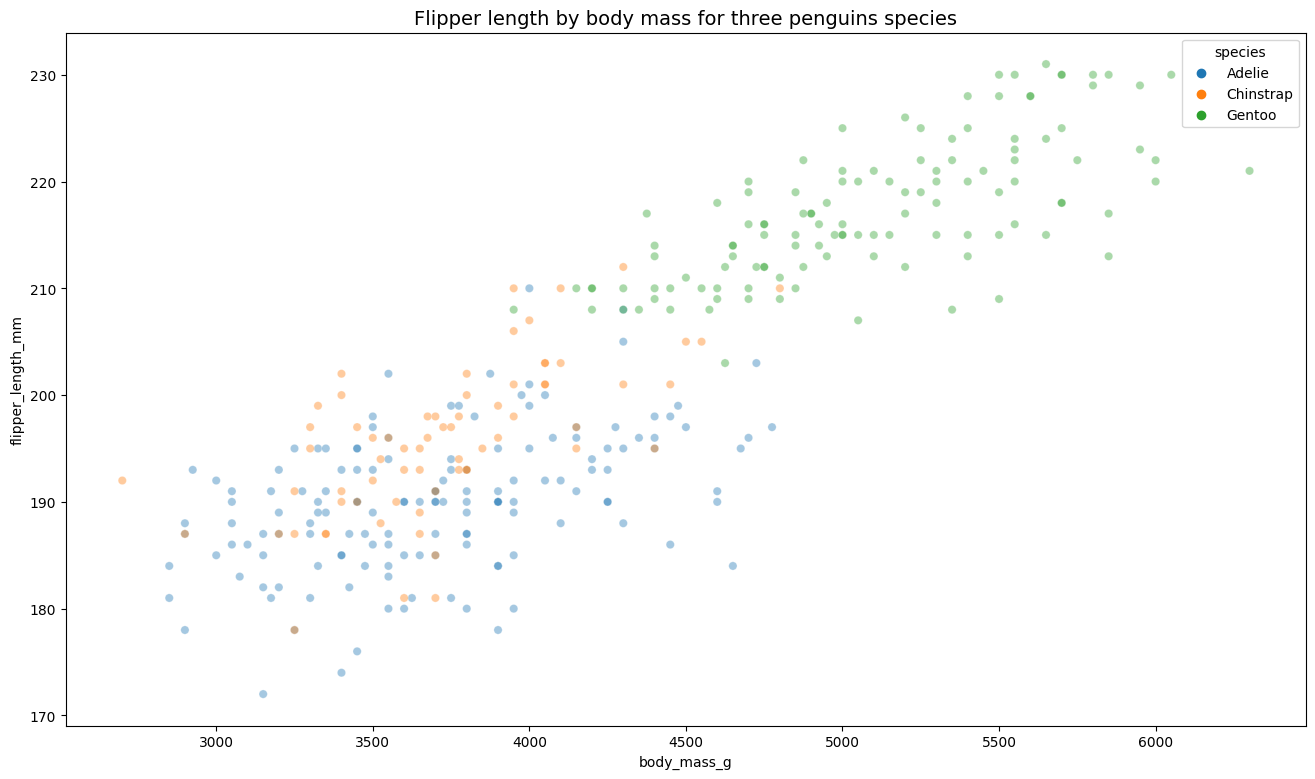

In [50]:
# Cria gráfico de dispersão de `flipper_length_mm` by e `body_mass_g` por espécie
plt.figure(figsize=(16, 9))
sns.scatterplot(data=dataset, x='body_mass_g', y='flipper_length_mm', hue='species', alpha=0.4)
plt.title('Flipper length by body mass for three penguins species', fontsize='14');

Este gráfico confirma os histogramas anteriores e sugere que os pinguins Gentoo são maiores, em média, do que os pinguins Adélie e Chinstrap.

### Separação dos dados em treino e teste

In [51]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset.values
X = array[:,1:5]
y = array[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

### Modelagem

KNN: 0.782906 (0.042498)
CART: 0.966382 (0.038976)
NB: 0.970228 (0.022274)
SVM: 0.741595 (0.042807)


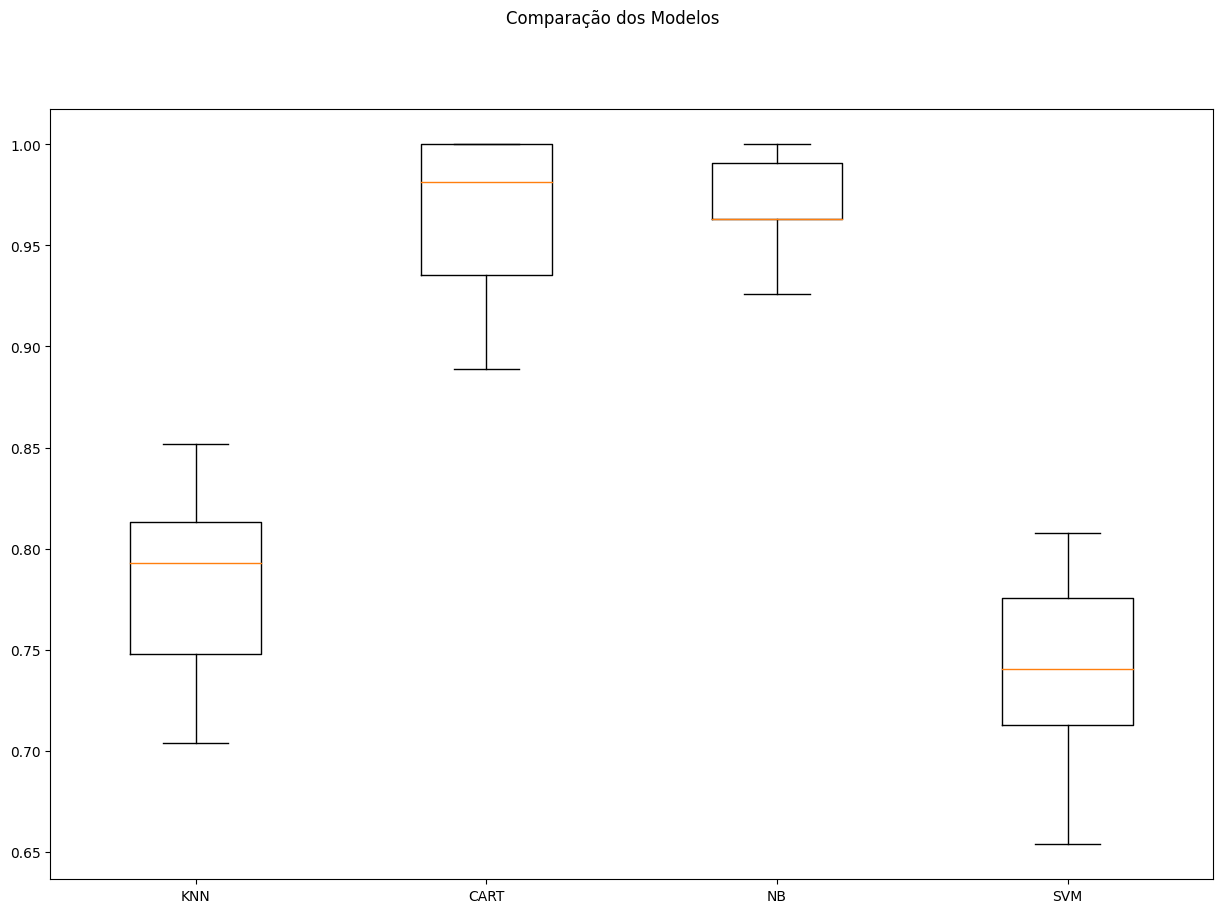

In [52]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Naive Bayes foi o modelo que melhor performou com os dados brutos. Proseeguimos com um teste de avaliação dos modelos a partir de dados normalizadoa e padronizados para comparação dos resultados.

### Avaliação dos modelos: dados normalizados e padronizados

KNN-orig: 0.783 (0.042)
CART-orig: 0.966 (0.039)
NB-orig: 0.970 (0.022)
SVM-orig: 0.742 (0.043)
KNN-padr: 0.989 (0.017)
CART-padr: 0.977 (0.030)
NB-padr: 0.970 (0.022)
SVM-padr: 0.985 (0.018)
KNN-norm: 0.989 (0.017)
CART-norm: 0.966 (0.039)
NB-norm: 0.970 (0.022)
SVM-norm: 0.985 (0.018)


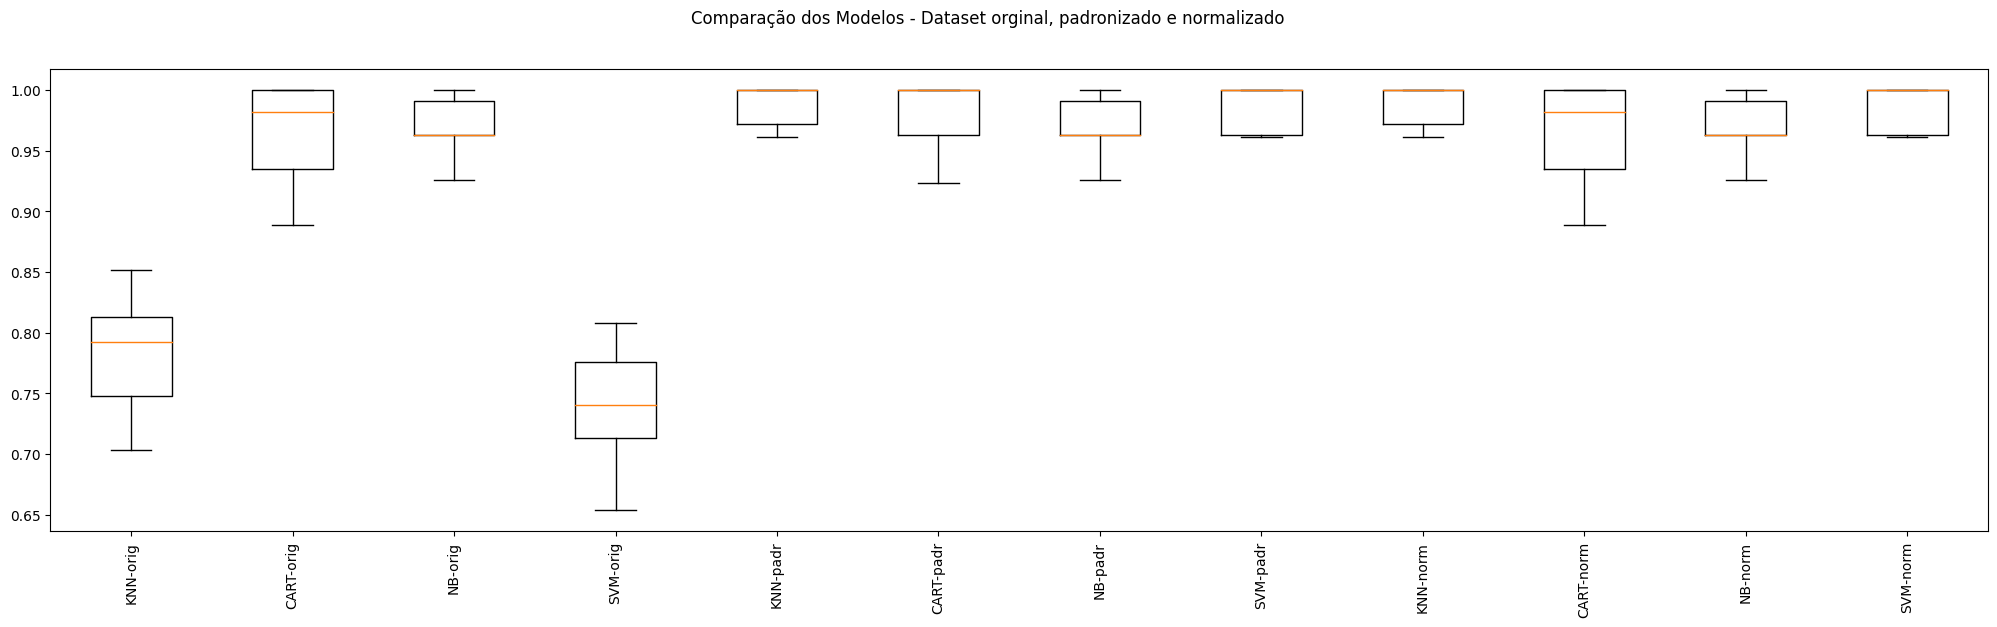

In [53]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

O modelo KNN normalizado foi o que obteve maior acurácia de todos, sendo assim selecionado para implementação. O modelo segue para a etapa de otimização de hiperparâmetros visando melhorar ainda mais a performance e efetuar possíveis 'ajustes finos' para obtermos a melhor predição possível.


### Otimização de hiperparâmetros

In [54]:
# Tuning do KNN

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn])))
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: knn-orig - Melhor: 0.868661 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 1}
Sem tratamento de missings: knn-padr - Melhor: 0.988746 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 5}
Sem tratamento de missings: knn-norm - Melhor: 0.988746 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 3}


O número ideal de neighbors identificado é 3 ou 5 e a melhor métrica para ser utilizada é 'euclidean'. Tais hiperparâmetros serão aplicados abaixo.

### Finalização do modelo

In [55]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = KNeighborsClassifier(metric='euclidean', n_neighbors=3)
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

0.9850746268656716


In [56]:
# Preparação do modelo com o dataset completo
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

### Simulação: aplicação do modelo em dados não vistos

Simulação de um pipeline de produção para avaliar o comportamento do modelo deployado.

In [57]:
dataset.head()

,species,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,39.1,18.7,181.0,3750.0
1,Adelie,39.5,17.4,186.0,3800.0
2,Adelie,40.3,18.0,195.0,3250.0
4,Adelie,36.7,19.3,193.0,3450.0
5,Adelie,39.3,20.6,190.0,3650.0


In [58]:
# Novos dados que não sabemos a espécie
data = {'culmen_length_mm':  [39.5, 49.8, 39.2],
        'culmen_depth_mm': [19.0, 14, 17.9],
        'flipper_length_mm': [194.0, 211.0, 187.0],
        'body_mass_g': [3700.0, 5100.0, 3650.0],
        }

atributos = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:8].astype(float)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

[[-0.82429023  0.93616143 -0.50102748 -0.63344654]
 [ 1.0648066  -1.60841798  0.71315692  1.10864787]
 [-0.87931247  0.37635396 -1.00098577 -0.6956642 ]]


In [59]:
# Predição de classes dos dados de entrada
#diagnosis = model.predict(rescaledEntradaX)
#diagnosis[0]

saidas = model.predict(rescaledEntradaX)
print(saidas)

['Adelie' 'Gentoo' 'Adelie']


### Salva modelo treinado

In [60]:
# export do modelo em pickle file
pickle_out = open('classificador.pkl', 'wb')
pickle.dump(model, pickle_out)
pickle_out.close()

## Conclusão e ficha técnica

### K-Nearest Neighbords

O K-Nearest Neighbors (KNN) é um algoritmo de aprendizado de máquina supervisionado usado para classificação e regressão. Ele é baseado em um princípio fundamental: objetos semelhantes tendem a estar próximos uns dos outros.

Resumo do pipeline do KNN:

Medida de Similaridade: Para classificar um novo ponto de dados, o KNN calcula a medida de similaridade entre esse ponto e todos os pontos de dados de treinamento. A medida de similaridade mais comum é a distância euclidiana, mas outras métricas, como a distância de Manhattan ou a distância de Minkowski, também podem ser usadas. Quanto menor a distância entre dois pontos, mais semelhantes eles são.

Seleção dos Vizinhos Mais Próximos: Após calcular as medidas de similaridade entre o novo ponto e os pontos de treinamento, o KNN seleciona os "K" pontos de treinamento mais próximos ao novo ponto. O valor de "K" é um hiperparâmetro que deve ser definido pelo usuário. A escolha de um valor adequado para "K" é importante e afeta o desempenho do algoritmo.

Classificação (ou Regressão): Para classificação, o KNN atribui uma classe ao novo ponto de dados com base na classe mais comum entre os "K" vizinhos mais próximos. Por exemplo, se a maioria dos vizinhos mais próximos pertence à classe A, o novo ponto é classificado como pertencente à classe A.

Avaliação do Modelo: O desempenho do modelo KNN pode ser avaliado usando métricas apropriadas, como precisão, acurácia, etc. Também é importante usar técnicas de validação cruzada para estimar o desempenho do modelo em dados não vistos.


### Ficha técnica: Penguin Classifier

*   Modelo utilizado: KNN
*   Técnicas aplicadas: normalização e padronização
*   Medida de similaridade: euclidiana
*   Número de vizinhos: 3
*   Métrica de Avaliação: acurácia
*   Performance alcançada com a métrica de avaliação: 0.98 (98%)
*   Casos de uso/limitações: modelo dependente dos dados de entrada. Se alguma das espécies tiver dados de entrada muito reduzido, há a possibilidade de afetar o re-treino do modelo e prejudicar a classificação.